# Customer Churn Prediction

## Importing Dependincies

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings("ignore")

## Load dataset 

In [120]:
df = pd.read_csv("data.csv",)

In [121]:
df.head() # Displaying first 5 row of the dfset.

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Changing dataset column names to proper names

In [122]:
for x in df.columns:
    print(x.lower())

rownumber
customerid
surname
creditscore
geography
gender
age
tenure
balance
numofproducts
hascrcard
isactivemember
estimatedsalary
exited


In [123]:
df.columns = [(lambda x: x.lower())(x) for x in df.columns] # Convert column names to lower for easy usage

In [124]:
df.head()

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Data Analysis 

### Getting basic informations on data.

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           10000 non-null  int64  
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


- No NaN values.

In [126]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rownumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
customerid,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
creditscore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
numofproducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
hascrcard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
isactivemember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
estimatedsalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


### Plotting target class value counts

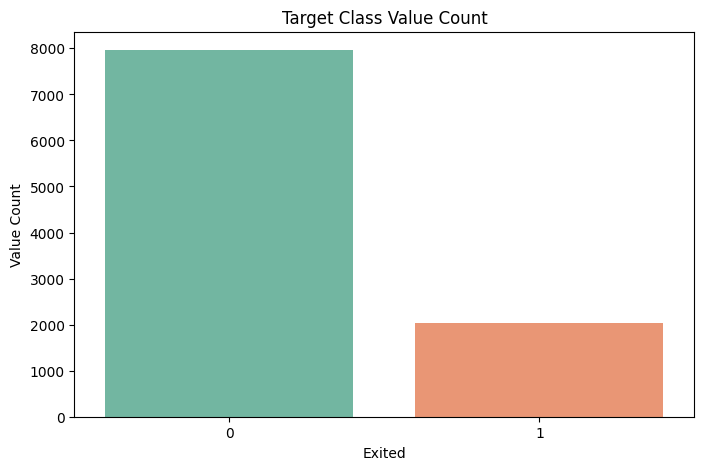

In [127]:
plt.figure(figsize=(8,5))
sns.countplot(x = "exited", data=df, palette = "Set2",)
plt.xlabel("Exited")
plt.ylabel("Value Count")
plt.title("Target Class Value Count")
plt.show()

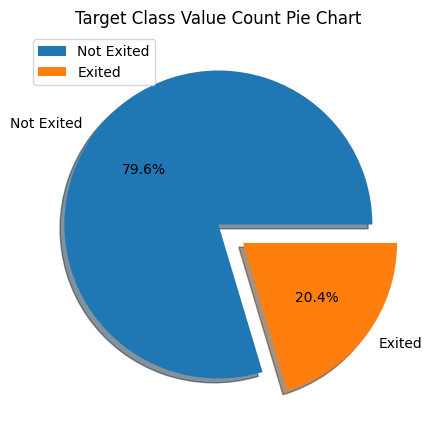

In [128]:
plt.figure(figsize=(8,5))
my_labels = ["Not Exited", "Exited"]
my_explode = [0, .2]
plt.pie(df["exited"].value_counts(), labels=my_labels, explode=my_explode, shadow=True, autopct="%1.1f%%")
plt.legend()
plt.title("Target Class Value Count Pie Chart")
plt.show()

### NaN Values 

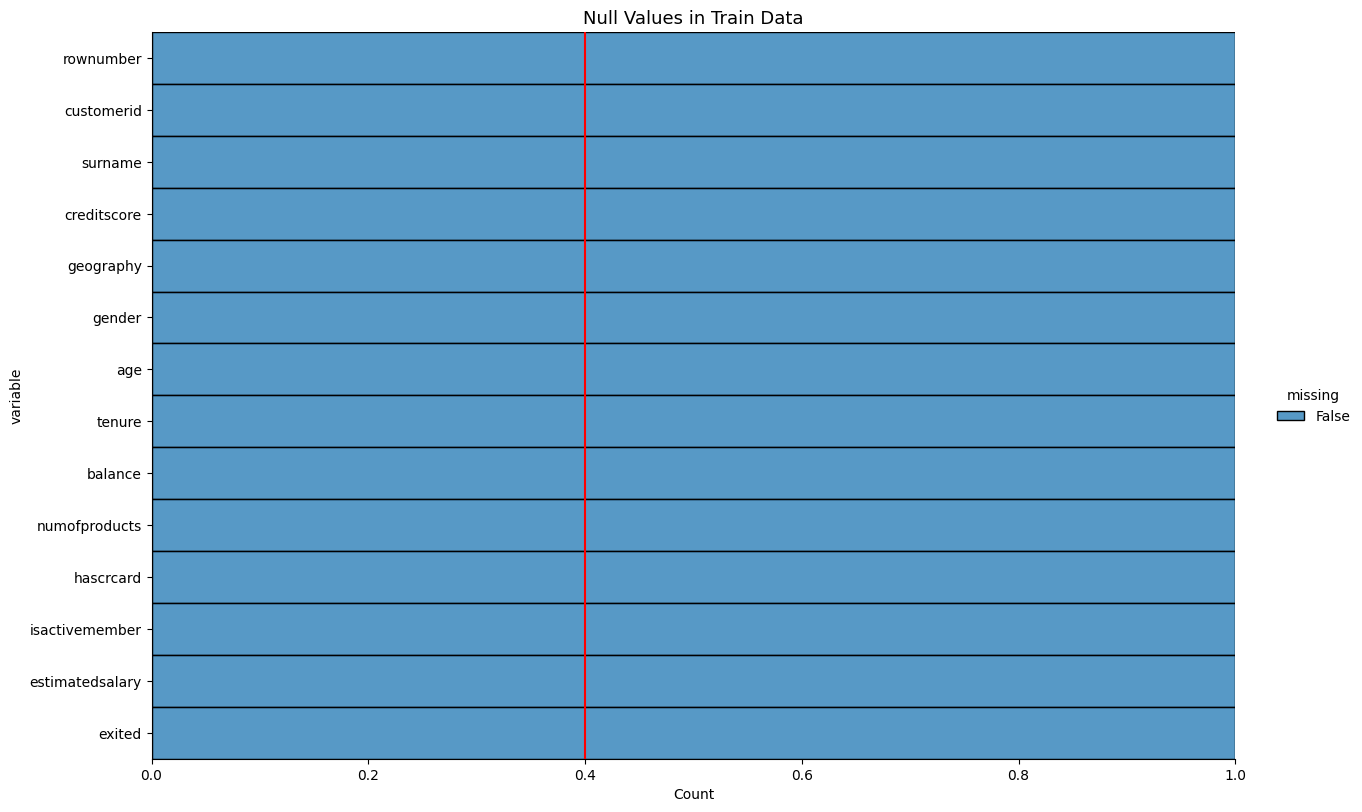

In [129]:
sns.displot(data=df.isnull().melt(value_name='missing'),
    y='variable',
    hue='missing',
    multiple='fill',
    height=8,
#     width=10,
    aspect=1.6
)

# specifying a threshold value
plt.axvline(0.4, color='r')
plt.title('Null Values in Train Data', fontsize=13)
plt.show()



### Categorical Values Analysis

In [130]:
df.select_dtypes(include="object").columns # Getting string type objects, we also have 4 more int type object.

Index(['surname', 'geography', 'gender'], dtype='object')

In [131]:
df.head()

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


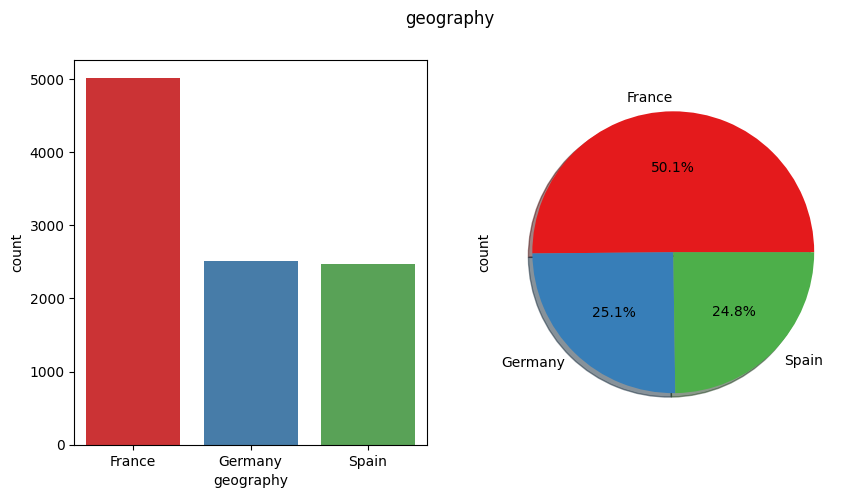

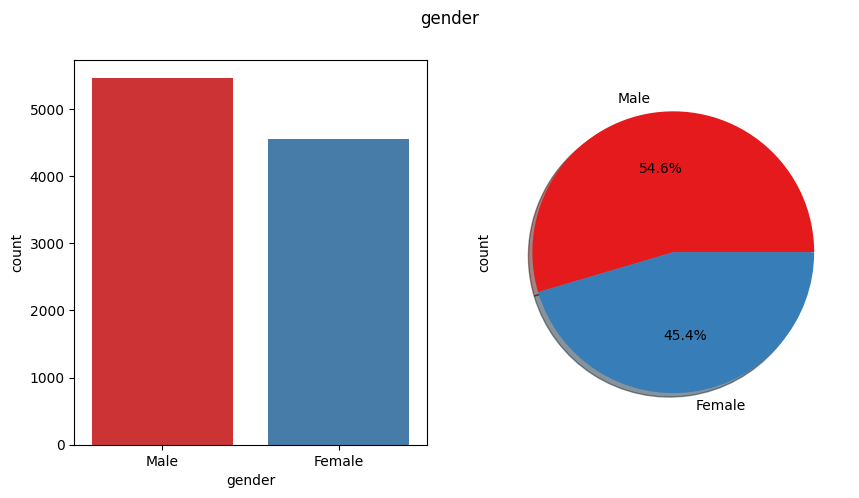

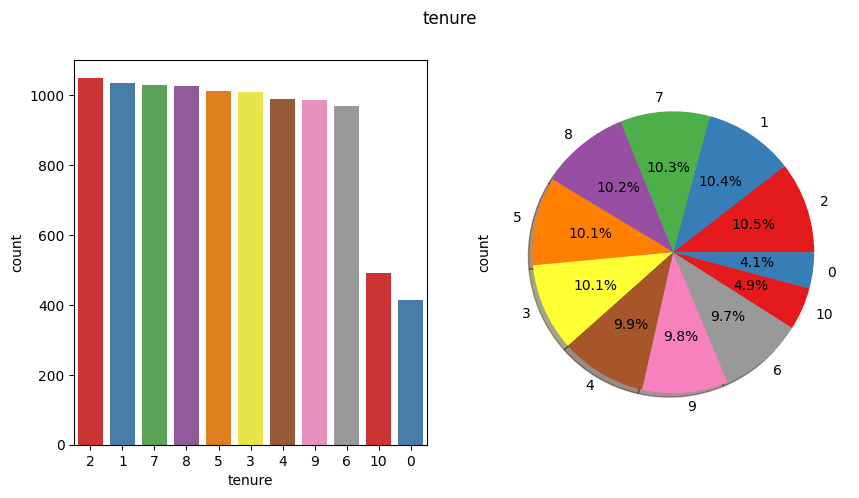

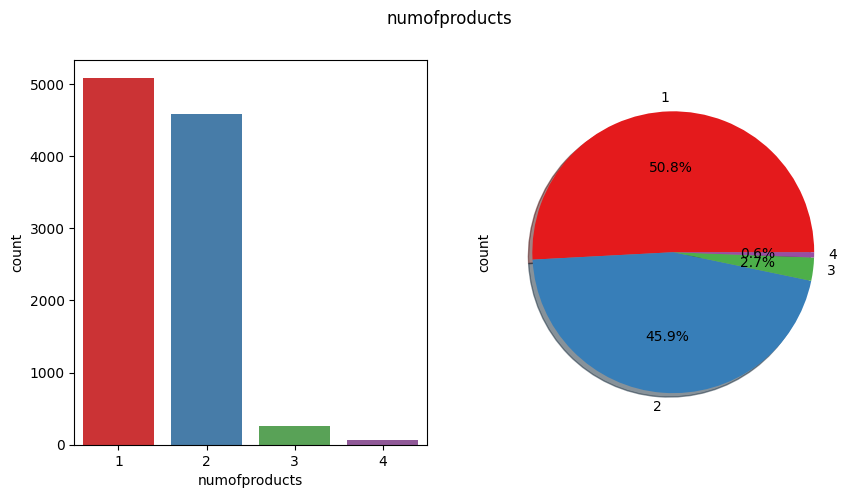

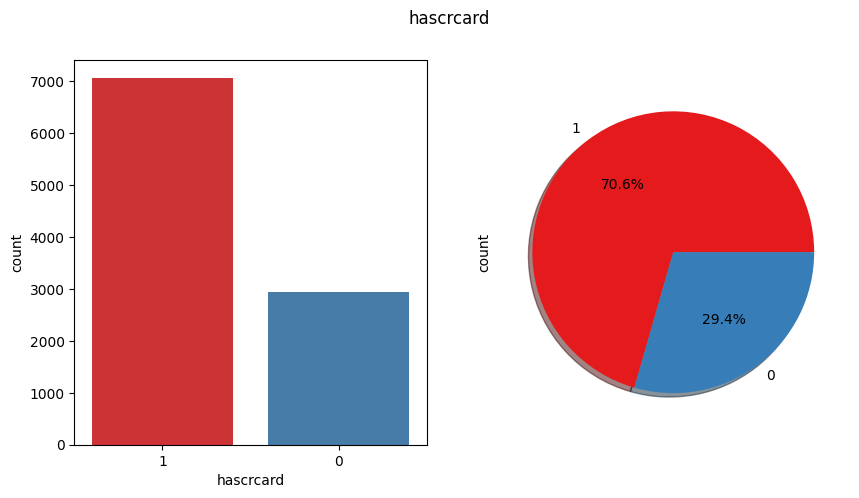

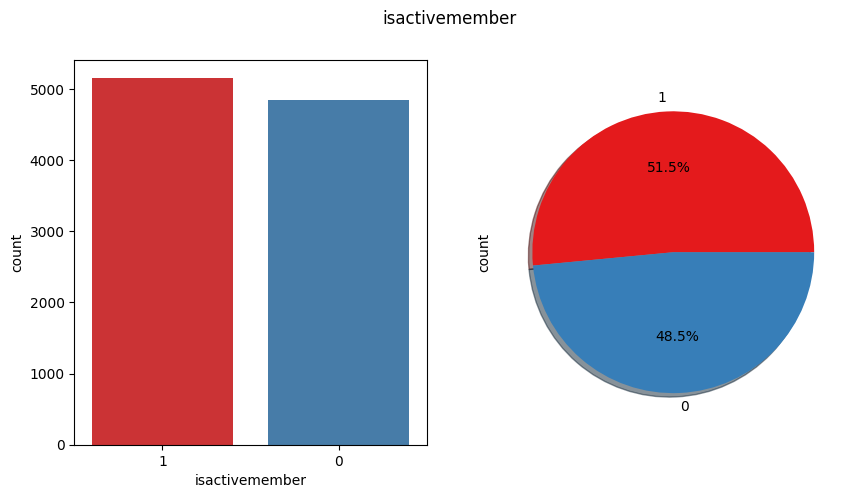

In [132]:
categorical_features = ["geography", "gender", "tenure", "numofproducts", "hascrcard", "isactivemember"]

for column in categorical_features:
    f, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.countplot(x=column, data=df, ax=ax[0], palette="Set1", order = df[column].value_counts().index)
    df[column].value_counts().plot.pie(autopct="%1.1f%%", ax=ax[1], shadow=True, colors=sns.color_palette("Set1"),)
    ax[1].set_label(f"{column}")
    plt.suptitle(f'{column}')
    plt.show()

### Correlation Analysis

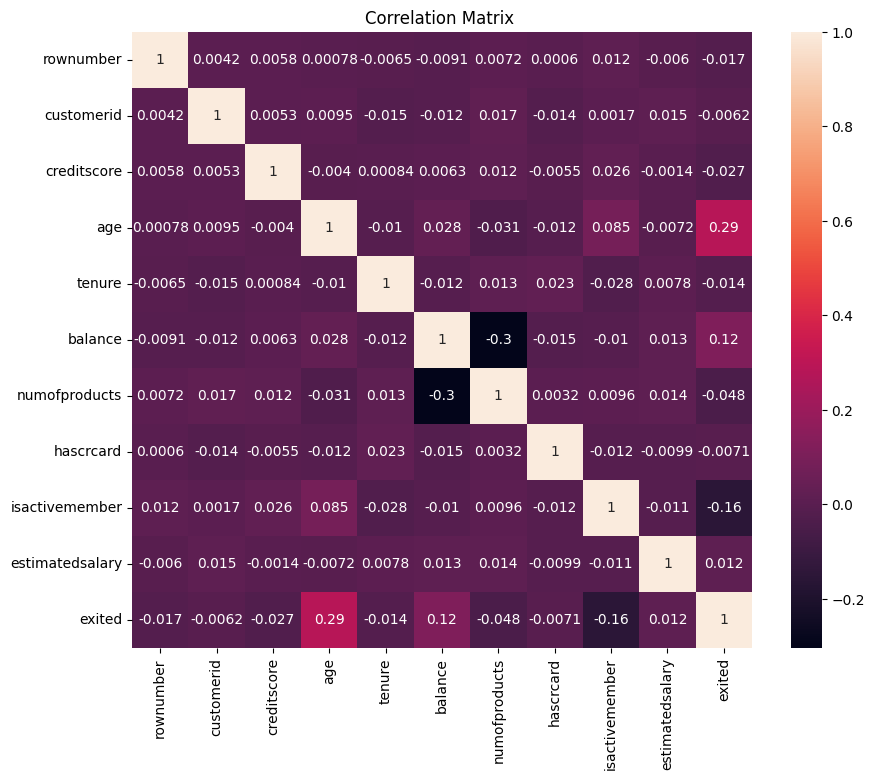

In [133]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True)
plt.title("Correlation Matrix ")
plt.show()

### Numeric Values Analysis

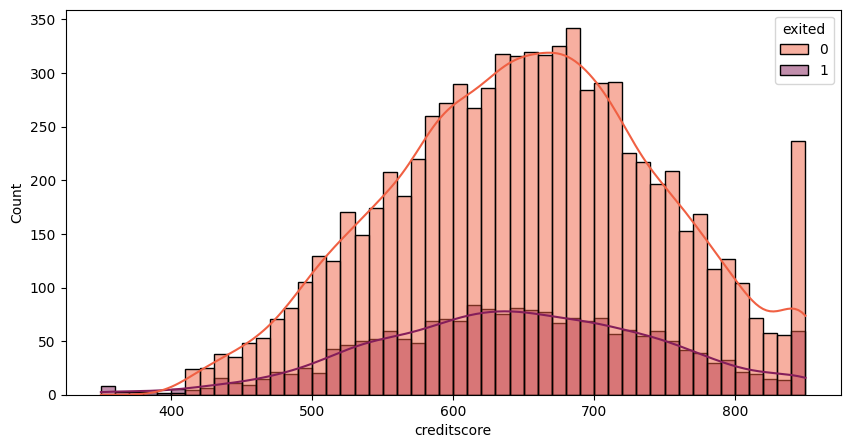

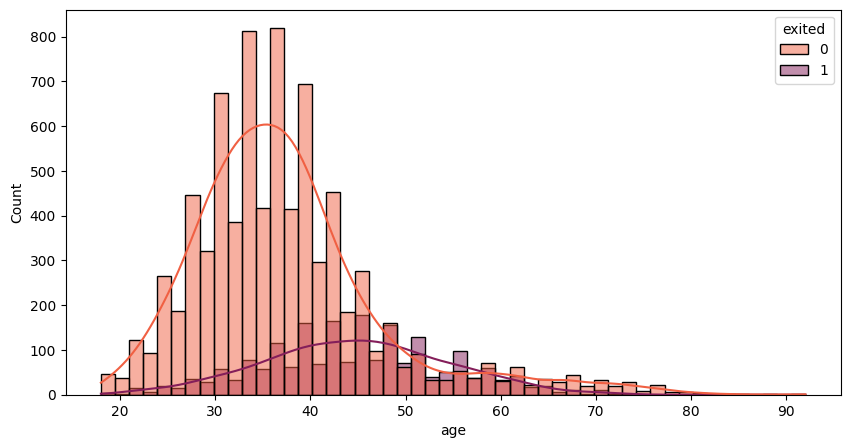

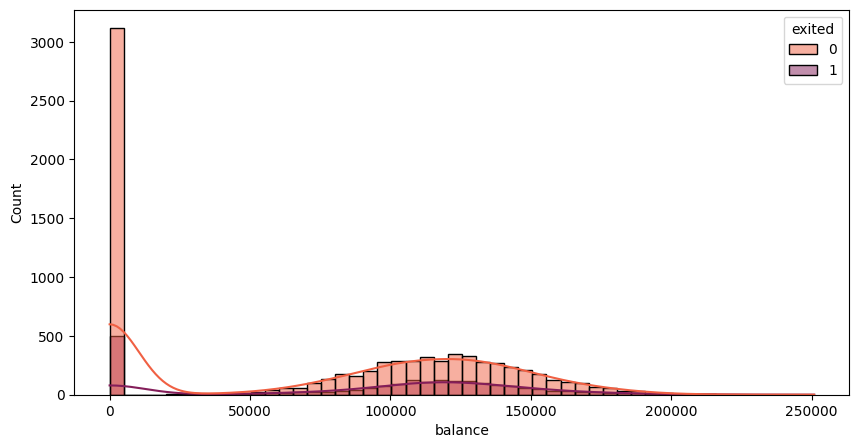

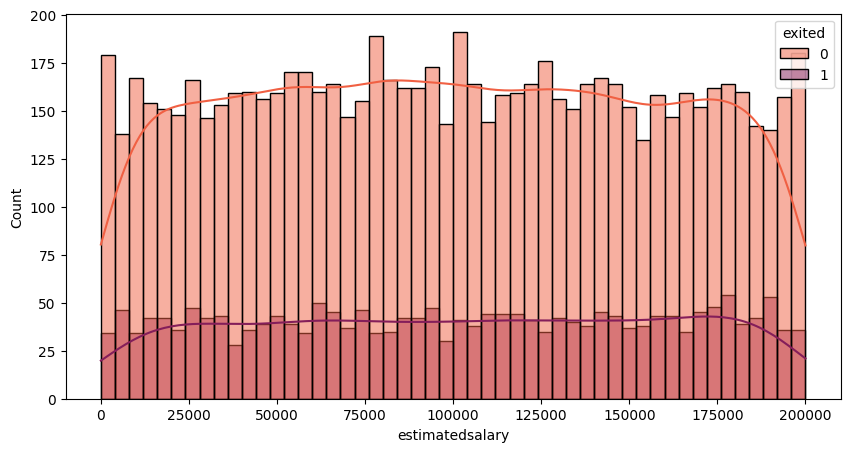

In [134]:
numeric_features = ["creditscore", "age", "balance", "estimatedsalary"]

for column in numeric_features:
    fig, ax = plt.subplots(figsize=(10, 5))
    fig = sns.histplot(data=df, x=column, hue="exited", bins=50, kde=True, palette="rocket_r")
    plt.show()

## Modeling

In [135]:
df.head(2)

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


In [136]:
# Removing uneeded columns
unneeded_cols = ["rownumber", "customerid", "surname", "exited"]

In [137]:
X = df.drop(unneeded_cols, axis=1)
y = df["exited"]

In [161]:
X.head(2)

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58


In [139]:
y.head(2)

0    1
1    0
Name: exited, dtype: int64

### One Hot Encoding The Categorical Variables

In [151]:
X_encoded = pd.get_dummies(X, columns=["geography", "gender", "numofproducts", "hascrcard", "isactivemember"])



In [152]:
X_encoded.head(3)

,creditscore,age,tenure,balance,estimatedsalary,geography_France,geography_Germany,geography_Spain,gender_Female,gender_Male,numofproducts_1,numofproducts_2,numofproducts_3,numofproducts_4,hascrcard_0,hascrcard_1,isactivemember_0,isactivemember_1
0,619,42,2,0.00,101348.88,True,False,False,True,False,True,False,False,False,False,True,False,True
1,608,41,1,83807.86,112542.58,False,False,True,True,False,True,False,False,False,True,False,False,True
2,502,42,8,159660.80,113931.57,True,False,False,True,False,False,False,True,False,False,True,True,False


### Splitting Data 

In [153]:
sum(y)/len(y)

0.2037

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=.2, random_state=42, stratify=y)

### Creating the Model

In [155]:
clf_xgb_v1 = xgb.XGBClassifier(objective='binary:logistic',
                            n_estimators = 500, learning_rate = 0.1,verbosity = 1, early_stopping_rounds = 10,eval_metric="auc",
                            seed=42)

clf_xgb_v1.fit(X_train,
            y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.83217
[1]	validation_0-auc:0.83426
[2]	validation_0-auc:0.84295


[3]	validation_0-auc:0.84182
[4]	validation_0-auc:0.84348
[5]	validation_0-auc:0.84473
[6]	validation_0-auc:0.84708
[7]	validation_0-auc:0.84897
[8]	validation_0-auc:0.84922
[9]	validation_0-auc:0.85026
[10]	validation_0-auc:0.85230
[11]	validation_0-auc:0.85256
[12]	validation_0-auc:0.85157
[13]	validation_0-auc:0.85238
[14]	validation_0-auc:0.85142
[15]	validation_0-auc:0.85188
[16]	validation_0-auc:0.85232
[17]	validation_0-auc:0.85245
[18]	validation_0-auc:0.85240
[19]	validation_0-auc:0.85363
[20]	validation_0-auc:0.85374
[21]	validation_0-auc:0.85369
[22]	validation_0-auc:0.85406
[23]	validation_0-auc:0.85438
[24]	validation_0-auc:0.85434
[25]	validation_0-auc:0.85578
[26]	validation_0-auc:0.85600
[27]	validation_0-auc:0.85604
[28]	validation_0-auc:0.85635
[29]	validation_0-auc:0.85638
[30]	validation_0-auc:0.85602
[31]	validation_0-auc:0.85608
[32]	validation_0-auc:0.85599
[33]	validation_0-auc:0.85586
[34]	validation_0-auc:0.85626
[35]	validation_0-auc:0.85602
[36]	validation_0

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

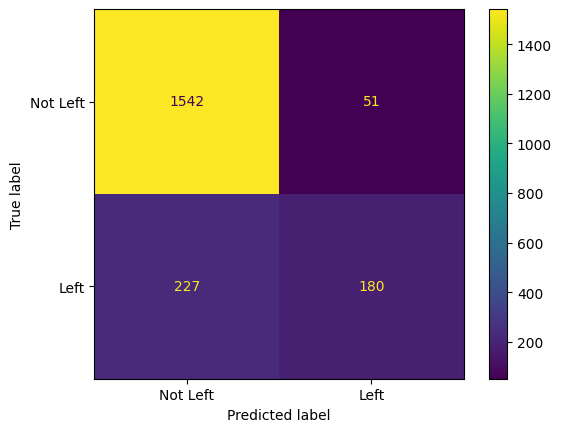

In [157]:
y_pred = clf_xgb_v1.predict(X_test)

conf_m = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_m, display_labels=['Not Left', 'Left'])
disp.plot()
plt.show()